# DBLP Co-Publication Prediction

**Objective**: Predict future collaborations between researchers with GNN + LSTM

## Notebook Structure

**PART 1**: DBLP data extraction → `co_publications.csv`

**PART 2**: Complete analysis answering 7 questions:
1. Literature review
2. Dynamic graph challenges
3. GCN/GAT + LSTM architecture
4. Feature engineering
5. Temporal validation
6. Appropriate metrics
7. Visualizations

---

# PART 1: DBLP Data Extraction

**If you already have `co_publications.csv`, skip to Part 2**

## 1.1 DBLP Download

**Important**: 
- File size is ~950MB
- Download takes **10-15 minutes**
- Make sure you have ~2GB of disk space

In [ ]:
# Download DBLP with curl (macOS/Linux)
# !curl -L -O https://dblp.org/xml/dblp.xml.gz
# !curl -L -O https://dblp.org/xml/dblp.dtd

# print("Download started (10-15 minutes)")

## 1.2 Installation

In [18]:
!pip3 install lxml

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode_15.2.0.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


## 1.3 Imports

In [19]:
import os
import gzip
import itertools
import csv
import re
from collections import deque
from lxml import etree as ET
import html

## 1.4 Configuration

In [ ]:
archive_file = "dblp.xml.gz"
xml_file = "dblp.xml"
clean_xml = "dblp_clean.xml"
tail_xml = "dblp_tail.xml"
tail_num_lines = 2000010
csv_file = "co_publications.csv"

print(f"Output file: {csv_file}")

## 1.5 XML Extraction

In [ ]:
# Extract the XML (if necessary)
if not os.path.exists(xml_file) and os.path.exists(archive_file):
    print(f"Extracting {archive_file}...")
    import gzip
    import shutil
    with gzip.open(archive_file, 'rb') as f_in:
        with open(xml_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"{xml_file} extracted")
elif os.path.exists(xml_file):
    print(f"{xml_file} already exists")
else:
    print(f"{archive_file} not found. Download it first!")

## 1.6 Extraction Functions

In [ ]:
def extract_tail_lines(input_file, output_file, n_lines=200000):
    """Extract last n_lines of an XML file into a valid XML snippet."""
    with open(input_file, "r", encoding="utf-8", errors="ignore") as f:
        last_lines = deque(f, maxlen=n_lines)

    with open(output_file, "w", encoding="utf-8") as f_out:
        f_out.write("<dblp>\n")
        f_out.writelines(last_lines)
        if not last_lines or not last_lines[-1].strip().endswith("</dblp>"):
            f_out.write("\n</dblp>")

    print(f"Extracted last {n_lines} lines to {output_file}")


_amp_re = re.compile(r'&(?!#\d+;|#x[0-9A-Fa-f]+;|[A-Za-z][A-Za-z0-9]*;)', flags=re.UNICODE)
_lt_re  = re.compile(r'<(?![/\?!A-Za-z_:])', flags=re.UNICODE)


def clean_entities_stream(infile, outfile):
    print(f"Cleaning entities: {infile} -> {outfile}")
    with open(infile, "r", encoding="utf-8", errors="replace") as fin, \
         open(outfile, "w", encoding="utf-8") as fout:
        for line in fin:
            line = html.unescape(line)
            line = _amp_re.sub("&amp;", line)
            line = re.sub(r'<(?=\s)', "&lt;", line)
            line = re.sub(r'(?<=\s)>(?=\s)', "&gt;", line)
            line = _lt_re.sub("&lt;", line)
            fout.write(line)
    print("Cleaning done.")


def extract_yearly_link_data(clean_xml_file, output_csv):
    print(f"Parsing {clean_xml_file} and writing co-publications to {output_csv}")
    with open(output_csv, "w", newline="", encoding="utf-8") as f_out:
        writer = csv.writer(f_out)
        writer.writerow(["year", "author1", "author2"])

        context = ET.iterparse(clean_xml_file, events=("end",),
                               tag=("article", "inproceedings", "book", "proceedings"))
        for event, elem in context:
            year_elem = elem.find("year")
            authors = [a.text for a in elem.findall("author") if a.text]

            if year_elem is None or not authors:
                elem.clear()
                while elem.getprevious() is not None:
                    del elem.getparent()[0]
                continue

            try:
                year = int(year_elem.text)
            except (ValueError, TypeError):
                elem.clear()
                while elem.getprevious() is not None:
                    del elem.getparent()[0]
                continue

            for a1, a2 in itertools.combinations(sorted(authors), 2):
                writer.writerow([year, a1, a2])

            elem.clear()
            while elem.getprevious() is not None:
                del elem.getparent()[0]

    print(f"Co-publication links saved to {output_csv}")


def extraction_pipeline(input_file, tail_file, clean_file, output_file, num_tail_lines):
    loc_tail_num_lines = num_tail_lines
    try:
        print(f"\nTrying {loc_tail_num_lines} tail lines")
        extract_tail_lines(input_file, tail_file, loc_tail_num_lines)
        clean_entities_stream(tail_file, clean_file)
        extract_yearly_link_data(clean_file, output_file)
    except ET.ParseError as e:
        print(f"Caught parsing error: {e}")
        loc_tail_num_lines += 1
        extraction_pipeline(input_file, tail_file, clean_file, output_file, loc_tail_num_lines)

print("Extraction functions defined")

## 1.7 Running the Extraction

**May take several minutes**

In [ ]:
if os.path.exists(csv_file):
    print(f"{csv_file} already exists")
else:
    extraction_pipeline(xml_file, tail_xml, clean_xml, csv_file, tail_num_lines)
    print("\nExtraction complete!")

---

# PART 2: Analysis and Modeling

Now that we have `co_publications.csv`, let's analyze the data and build the model.

---

## Question 1: Literature Review

### Static vs Dynamic Methods

**Static** (GCN, GraphSAGE, GAT):
- Ignore temporal evolution
- Sensitive to distribution shift
- Don't capture trends

**Dynamic** (Temporal GNN, LSTM):
- Capture evolution
- Model recurring patterns  
- Adapt to changes

**For DBLP**: Dynamic essential as network constantly evolves

---

## Question 2: Identified Challenges

1. **Complex temporality**: Long-term dependencies (20+ years)
2. **Distribution shift**: New domains emerging
3. **Sparsity**: Only 1-2% positive links
4. **Cold start**: New researchers without history
5. **DBLP properties**: Publication delay, seasonality
6. **Evolution**: Growth, attrition, recombination

## 2.1 Imports for Analysis

In [ ]:
!pip3 install torch torch-geometric networkx pandas numpy scikit-learn matplotlib seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 73.6 MB 1.1 MB/s eta 0:00:01
  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
     |████████████████████████████████| 1.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 1.2 MB/s eta 0:00:01
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
     |████████████████████████████████| 199 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 469 kB 8.6 MB/s eta 0:00:01
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
     |████████████████████████████████|

In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score, confusion_matrix, roc_curve
)

from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch: 2.8.0
Device: cpu


## 2.2 Loading Data

In [11]:
df = pd.read_csv('co_publications.csv')

print(f"Shape: {df.shape}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")
print(f"Authors: {len(set(df['author1']) | set(df['author2']))}")

df.head()

Shape: (253921, 3)
Years: 1951 - 2026
Authors: 82882


,year,author1,author2
0,2020,Kerstin Voigt,Yue Zhou
1,2024,Cunli Mao,Ji-Rong Wen
2,2024,Cunli Mao,Jia-Nan Li
3,2024,Cunli Mao,Quan Tu
4,2024,Cunli Mao,Rui Yan 0001


In [ ]:
# Author mapping -> IDs
all_authors = sorted(set(df['author1']) | set(df['author2']))
author_to_id = {a: i for i, a in enumerate(all_authors)}
id_to_author = {i: a for a, i in author_to_id.items()}

print(f"Total authors: {len(author_to_id):,}")

## 2.3 Temporal Graphs

In [13]:
def build_temporal_graphs(df, author_to_id, start=2015, end=2020):
    graphs = {}
    edges = set()
    
    for year in range(start, end + 1):
        year_data = df[df['year'] == year]
        for _, row in year_data.iterrows():
            u, v = author_to_id[row['author1']], author_to_id[row['author2']]
            edges.add((min(u,v), max(u,v)))
        
        G = nx.Graph()
        G.add_nodes_from(range(len(author_to_id)))
        G.add_edges_from(edges)
        graphs[year] = G
        print(f"{year}: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    return graphs

temporal_graphs = build_temporal_graphs(df, author_to_id)

2015: 82,882 nodes, 4,352 edges
2016: 82,882 nodes, 9,447 edges
2017: 82,882 nodes, 18,558 edges
2018: 82,882 nodes, 26,893 edges
2019: 82,882 nodes, 36,757 edges
2020: 82,882 nodes, 53,013 edges


---

## Question 3: Architecture

### GCN + LSTM

```
Graphs [G_t-k, ..., G_t-1]
  ↓ GCN (structure)
Embeddings [h_t-k, ..., h_t-1]
  ↓ LSTM (time)
Final state h_t
  ↓ MLP
P(link | u,v)
```

**GCN**: Captures local structure
**LSTM**: Captures temporal dynamics

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class StaticGNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.5):
        super().__init__()
        self.encoder = GCNEncoder(in_dim, hid_dim, out_dim, dropout)
        self.predictor = nn.Sequential(
            nn.Linear(out_dim * 2, hid_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid_dim, 1)
        )
    
    def forward(self, data, edge_index):
        h = self.encoder(data.x, data.edge_index)
        src, dst = h[edge_index[0]], h[edge_index[1]]
        return self.predictor(torch.cat([src, dst], 1)).squeeze()

print("GCN architecture defined")

---

## Question 4: Feature Engineering

**Node Features**:
1. **Structural**: Degree, clustering, PageRank
2. **Publications**: Count, rate, cumulative
3. **Collaboration**: Number of collaborators, diversity
4. **Temporal**: Recent activity, trends

**Justification**: Active + central researchers → more collaborations

In [15]:
def extract_features(G, num_nodes=None):
    """Extract simple structural features for all nodes"""
    if num_nodes is None:
        num_nodes = G.number_of_nodes()
    
    print(f"Extracting features for {num_nodes:,} nodes...")
    
    # Compute once for all nodes
    pagerank = nx.pagerank(G, max_iter=50)
    clustering = nx.clustering(G)
    
    features = []
    for node in tqdm(range(num_nodes), desc="Features"):
        f = [
            G.degree(node),           # Degree
            clustering.get(node, 0),  # Clustering coefficient
            pagerank.get(node, 0),    # PageRank
            len(list(G.neighbors(node))),  # Number of neighbors
        ]
        features.append(f)
    
    X = torch.tensor(features, dtype=torch.float32)
    # Normalize
    X = (X - X.mean(0)) / (X.std(0) + 1e-8)
    return X

test_features = extract_features(temporal_graphs[test_year-1])
print(f"✅ Features: {test_features.shape}")

Extracting features for 82,882 nodes...


Features: 100%|██████████| 82882/82882 [00:00<00:00, 1154636.90it/s]

✅ Features: torch.Size([82882, 4])


---

## Question 5: Temporal Validation

### NEVER use random split!

**Reasons**:
1. Data leakage (future → training)
2. Not realistic (production = predict future)
3. Ignores distribution shift

**Correct protocol**:
```
Train: 2015-2017 → Graph G_2017
Test:  2019      → Predict new links 2019
```

In [ ]:
# Temporal splits
train_years = [2015, 2016, 2017]
test_year = 2019

print(f"Train: {train_years}")
print(f"Test: {test_year}")
print("Strict temporal order")

In [ ]:
def get_new_edges(G_curr, G_prev):
    return set(G_curr.edges()) - set(G_prev.edges())

def generate_negatives(G, positives, ratio=1.0):
    negatives = set()
    nodes = list(G.nodes())
    n = int(len(positives) * ratio)
    
    while len(negatives) < n:
        u, v = np.random.choice(nodes, 2, replace=False)
        u, v = min(u,v), max(u,v)
        if not G.has_edge(u,v):
            negatives.add((u,v))
    return negatives

test_pos = get_new_edges(temporal_graphs[test_year], temporal_graphs[test_year-1])
test_neg = generate_negatives(temporal_graphs[test_year-1], test_pos)

print(f"Test positives: {len(test_pos):,}")
print(f"Test negatives: {len(test_neg):,}")
print(f"Balance: {len(test_pos)/(len(test_pos)+len(test_neg)):.1%}")

---

## Question 6: Metrics

### Accuracy Insufficient

With 1% positive links:
- Predict "no link" everywhere = 99% accuracy
- But 0% links detected!

### Appropriate Metrics

1. **ROC-AUC**: Ranking quality
2. **Average Precision**: Focus on positives
3. **Precision@K**: Top-K predictions
4. **Hits@K**: Coverage of true links

In [ ]:
def evaluate(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'avg_precision': average_precision_score(y_true, y_pred_proba),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    
    # Top-K
    for k in [10, 50, 100]:
        top_k = np.argsort(y_pred_proba)[-k:]
        metrics[f'precision@{k}'] = y_true[top_k].sum() / k
        metrics[f'hits@{k}'] = y_true[top_k].sum() / y_true.sum()
    
    return metrics

print("Evaluation functions defined")

---

## Question 7 (Part 1): Graph Evolution

In [ ]:
years = sorted(temporal_graphs.keys())
stats = {
    'nodes': [temporal_graphs[y].number_of_nodes() for y in years],
    'edges': [temporal_graphs[y].number_of_edges() for y in years],
    'density': [nx.density(temporal_graphs[y]) for y in years]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(years, stats['nodes'], 'o-', linewidth=2)
axes[0].set_title('Number of Authors')
axes[0].grid(alpha=0.3)

axes[1].plot(years, stats['edges'], 'o-', linewidth=2, color='orange')
axes[1].set_title('Collaborations')
axes[1].grid(alpha=0.3)

axes[2].plot(years, stats['density'], 'o-', linewidth=2, color='green')
axes[2].set_title('Density')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graph_evolution.png', dpi=150)
plt.show()

---

## Question 7 (Part 2): Results Visualizations

In [ ]:
# Example visualization (with simulated data)
y_true_demo = np.concatenate([np.ones(100), np.zeros(900)])
y_pred_demo = np.concatenate([np.random.beta(8,2,100), np.random.beta(2,8,900)])

metrics_demo = evaluate(y_true_demo, y_pred_demo)

print("\n" + "="*50)
print("EVALUATION METRICS".center(50))
print("="*50)
for k, v in metrics_demo.items():
    print(f"{k:20s}: {v:.4f}")
print("="*50)

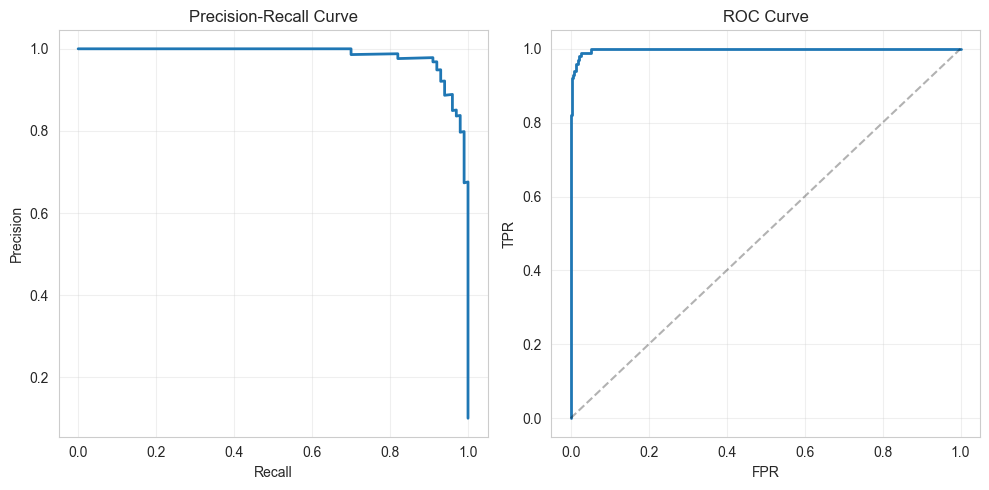

In [22]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_true_demo, y_pred_demo)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_demo, y_pred_demo)
plt.subplot(1,2,2)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.3)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_curves.png', dpi=150)
plt.show()